In [1]:
%matplotlib inline
from __future__ import division
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image

from matplotlib.gridspec import GridSpec

# TODO try to avoid the need of the sys.path.apppend call
import sys
sys.path.append("..")
from cwc.models.density_estimators import MyMultivariateNormal
from cwc.models.density_estimators import MultivariateNormal
from cwc.models.background_check import BackgroundCheck
from cwc.models.confident_classifier import ConfidentClassifier

from scipy.special import logit
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity

# For reproducibility
seed = 42

# Avoid problems with pdfpc and fonts
plt.rc('pdf', fonttype=42)
plt.rc('ps',  fonttype=42)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4,3)

# set precision of floats
np.set_printoptions(precision=2, suppress=True)

### helper functions
def affine_bias(z, mu0=0.5, mu1=0.5):
    if mu0 == mu1:
        return mu0
    return (1-z)*mu0 + z*mu1

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)
    

def ax_scatter_question(ax, x, notes, zorder=2, clip_on=True, text_size=18, color='w'):
    ax.scatter(x[:,0], x[:,1], c=color, s=500, zorder=zorder, clip_on=clip_on)

    for point, n in zip(x, notes):
        ax.annotate('{}'.format(n), xy=(point[0],point[1]), xytext=(point[0],point[1]),
                    ha="center", va="center", size=text_size, zorder=zorder, clip_on=clip_on)
        
def plot_points_predictions(fig, x, y, Z, MX1, MX2, x_predict=None, notes=None, cmap=cm.plasma_r, cmap_r=cm.plasma, loc='lower right', levels=None, alpha=0.7):
    x1_min, x1_max = MX1.min(), MX1.max()
    x2_min, x2_max = MX2.min(), MX2.max()
    
    ax = fig.add_subplot(1,1,1)

    print "length of unique values = {}".format(len(np.unique(Z)))
    if len(np.unique(Z)) > 1:
        # Colormap
        im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                       cmap=cmap_r, extent=(x1_min, x1_max, x2_min, x2_max),
                       alpha=alpha)

        # Contour
        CS = ax.contour(MX1, MX2, Z, levels=levels, cmap=cmap)
        ax.clabel(CS, fontsize=13, inline=1)
    else:
        print "Unique value = ", np.unique(Z)[0]
        ax.set_axis_bgcolor((1,1-np.unique(Z)[0],1-np.unique(Z)[0]))
        
    ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
    ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
    ax.grid(True)
    
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    
    if x_predict is not None:
        ax_scatter_question(ax, x_predict, notes)
    ax.legend(loc=loc)
    
    return ax
    
    
def plot_points(fig, x, y, MX1, MX2, x_predict=None, notes=None, loc='upper right'):
    x1_min, x1_max = MX1.min(), MX1.max()
    x2_min, x2_max = MX2.min(), MX2.max()
    
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
    ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
    ax.grid(True)
    ax.legend(loc=loc)
    
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    
def posterior_probs(q_f, p_c1_g_f_x, p_c2_g_f_x, mu0=0.5, mu1=0.5):
        q_b = (1-q_f)*mu0 + q_f*mu1
        if mu0 == mu1 == 0:
            r = np.zeros_like(q_b)
            p_c1_f_g_x = p_c1_g_f_x
            p_c2_f_g_x = p_c2_g_f_x
            p_b_g_x = np.zeros_like(q_b)
        else:
            r = q_f/q_b
            p_c1_f_g_x = (p_c1_g_f_x*r)/(1 + r)
            p_c2_f_g_x = (p_c2_g_f_x*r)/(1 + r)
            p_b_g_x = 1/(1+r)

            # For numerical precision
            p_b_g_x[r==1] = 1
            p_c1_f_g_x[q_b==0] = p_c1_g_f_x[q_b==0]
            p_c2_f_g_x[q_b==0] = p_c2_g_f_x[q_b==0]
        return p_c1_f_g_x, p_c2_f_g_x, p_b_g_x

# Definition of some colors for the heatmaps
from matplotlib.colors import LinearSegmentedColormap
    
cm_ra = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
red_alpha = LinearSegmentedColormap('RedAlpha1', cm_ra)

cm_ya = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 1.0, 1.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
yellow_alpha = LinearSegmentedColormap('YellowAlpha1', cm_ya)

cm_ba = {'red': ((0.0, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'green': ((0.0, 1.0, 1.0),
                  (1.0, 0.0, 0.0)),
        'blue': ((0.0, 1.0, 1.0),
                  (1.0, 1.0, 1.0)),
        'alpha': ((0.0, 0.0, 0.0),
                  (1.0, 1.0, 1.0))}
blue_alpha = LinearSegmentedColormap('BlueAlpha1', cm_ba)

cmaps = [yellow_alpha, blue_alpha, red_alpha]

def plot_probabilities(p, extent=None, alpha=0.7):
    delta = int(np.sqrt(p.shape[0]))
    for i in range(p.shape[1]):
        example = p[:,i].flatten()[0]
        if not np.allclose(p[:,i], example):
            plt.imshow(p[:,i].reshape((delta,delta)), interpolation='bilinear',
                origin='lower', cmap=cmaps[i], extent=extent, alpha=alpha)
        else:
            # FIXME the unique value could be any posterior probability
            # now it is considering only the background (red)
            print "Unique value = ", example
            ax.set_axis_bgcolor((1,1-example,1-example))

# Motivation

/home/maikel/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


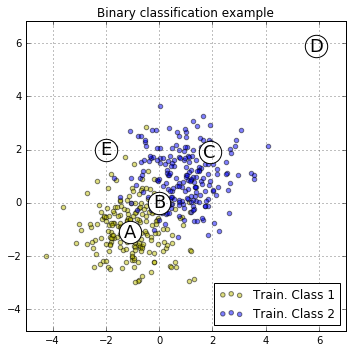

In [2]:
model_c1 = MyMultivariateNormal(mean=[-1, -1], cov=np.array([[1,0], [0,1]]))
model_c2 = MyMultivariateNormal(mean=[ 1,  1], cov=np.array([[1,0], [0,1]]))

np.random.seed(seed)
N = 200*2
x = np.concatenate((model_c1.sample(int(N/2)),
                    model_c2.sample(int(N/2))))
y = np.concatenate((np.zeros(int(N/2)),
                    np.ones(int(N/2))))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Binary classification example')
ax.scatter(x[y==0,0], x[y==0,1], c='y', alpha=0.5, label='Train. Class 1')
ax.scatter(x[y==1,0], x[y==1,1], c='b', alpha=0.5, label='Train. Class 2')
ax.grid(True)
        
ax.legend(loc='lower right')


x_predict = np.array([[-1.1,-1.1], [0,0], [1.9,1.9], [5.9,5.9], [-2,2]])
notes = ('A', 'B', 'C', 'D', 'E')

ax_scatter_question(ax, x_predict, notes)
plt.axis('equal')

x1_min, x1_max = (-5.0, 7.0)
x2_min, x2_max = (-5.0, 7.0)

ax.set_xlim([x1_min, x1_max])
ax.set_ylim([x2_min, x2_max])
fig.savefig('bc_fig_motiv.pdf')

We can train a model to classify these points. In this case an SVM with RBF kernel. Notice that the hyperparameters has been choosen with the only purpose of simplifying the table and the explanation.

In [3]:
clf = SVC(kernel='rbf', C=0.31, gamma=0.1, probability=True)
# clf = SVC(kernel='rbf', C=1.0, gamma=0.1, probability=True) # perfect for D = 0.5
clf.fit(x,y)
print clf.predict_proba(x_predict)

[[ 0.99  0.01]
 [ 0.47  0.53]
 [ 0.01  0.99]
 [ 0.51  0.49]
 [ 0.52  0.48]]


(230400, 2)
480.0
length of unique values = 225257


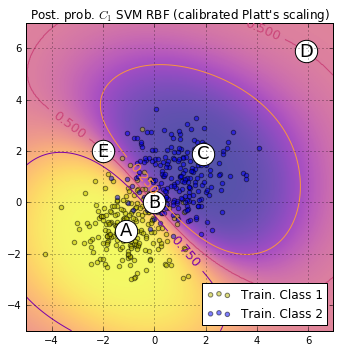

In [4]:
# Create a grid to visualize the predictions of our model
delta = 0.025
x1_grid = np.arange(x1_min, x1_max, delta)
x2_grid = np.arange(x2_min, x2_max, delta)
MX1, MX2 = np.meshgrid(x1_grid, x2_grid)
x_grid = np.asarray([MX1.flatten(),MX2.flatten()]).T

print x_grid.shape
print np.sqrt(x_grid.shape[0])

prediction = clf.predict_proba(x_grid)

Z = prediction[:,0].reshape(len(x2_grid), len(x1_grid))

fig = plt.figure(figsize=(5,5))
ax = plot_points_predictions(fig, x, y, Z, MX1, MX2, x_predict, notes, levels=[0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_title("Post. prob. $C_1$ SVM RBF (calibrated Platt's scaling)")
fig.savefig('bc_fig_motiv_svc_rbf_contour_platt.pdf')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: invalid value encountered in true_divide


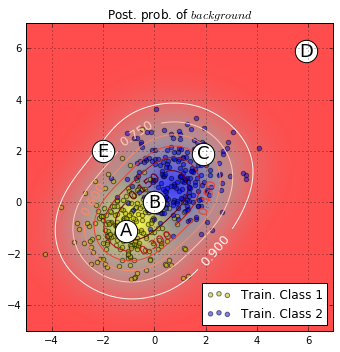

In [5]:
kde = KernelDensity()
kde.fit(x)
prediction_x = kde.score_samples(x)
prediction = np.exp(kde.score_samples(x_grid))

qf = prediction.reshape(len(x2_grid), len(x1_grid))
z_qf = qf/qf.max()

mu0 = 1.0
mu1 = 0.0

qb = affine_bias(z_qf,mu0,mu1)

fig = plt.figure(figsize=(5,5))

p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(z_qf, Z, 1-Z, mu0, mu1)

p_c1_c2_b_g_x = np.hstack((p_c1_f_g_x.reshape(-1,1), p_c2_f_g_x.reshape(-1,1), p_b_g_x.reshape(-1,1)))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.set_title("Post. prob. of $background$")

extent=(x1_min, x1_max, x2_min, x2_max)
plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
plot_points(fig, x, y, MX1, MX2, loc='lower right')


CS = ax.contour(MX1, MX2, p_b_g_x, cmap=cm.Reds_r)
ax.clabel(CS, fontsize=13, inline=1)
ax_scatter_question(ax, x_predict, notes)

fig.savefig('bc_fig_motiv_bcf_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

In [6]:
predict_marks_c1_c2 = clf.predict_proba(x_predict)

predict_marks_dens_f = np.exp(kde.score_samples(x_predict))
predict_marks_qf = predict_marks_dens_f/predict_marks_dens_f.max()

marks_p_c1_f_g_x, marks_p_c2_f_g_x, marks_p_b_g_x = posterior_probs(predict_marks_qf, predict_marks_c1_c2[:,0], predict_marks_c1_c2[:,1], mu0, mu1)
marks_p_c1_c2_b_g_x = np.vstack((marks_p_c1_f_g_x, marks_p_c2_f_g_x, marks_p_b_g_x)).T

print marks_p_c1_c2_b_g_x

[[ 0.91  0.01  0.08]
 [ 0.47  0.53  0.  ]
 [ 0.    0.49  0.51]
 [ 0.    0.    1.  ]
 [ 0.07  0.07  0.86]]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: invalid value encountered in true_divide


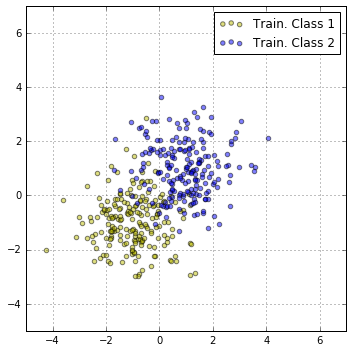

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
plot_points(fig, x, y, MX1, MX2)

fig.savefig('bc_fig_bcd_1.pdf')
fig.savefig('bc_fig_bcf_1.pdf')

length of unique values = 230400


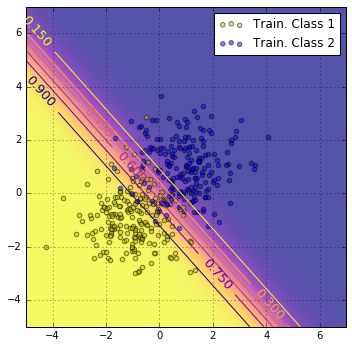

In [8]:
from sklearn.linear_model import LogisticRegression
import matplotlib.cm as cm

clf_c1_c2 = LogisticRegression()
clf_c1_c2.fit(x,y)

x_grid = np.asarray([MX1.flatten(),MX2.flatten()]).T

prediction_c1_c2 = clf_c1_c2.predict_proba(x_grid)

Z_c1_c2 = prediction_c1_c2[:,0].reshape(len(x2_grid), len(x1_grid))

fig = plt.figure(figsize=(5,5))
plot_points_predictions(fig, x, y, Z_c1_c2, MX1, MX2, loc='upper right')
fig.savefig('bc_fig_bcf_2.pdf')
fig.savefig('bc_fig_bcd_2.pdf')

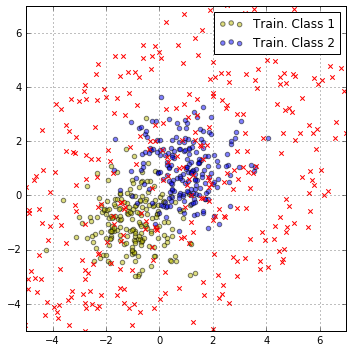

In [9]:
from reject import create_reject_data

b = create_reject_data(x, 1, 'uniform_hsphere', pca=True, pca_components=2, hshape_prop_in=1, hshape_multiplier=1.7)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
plot_points(fig, x, y, MX1, MX2)
ax.scatter(b[:,0], b[:,1], marker='x', c='r')

fig.savefig('bc_fig_bcd_3.pdf')

length of unique values = 230080


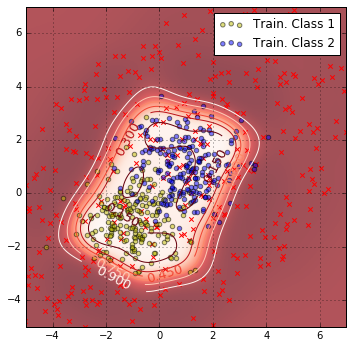

In [10]:
x_b = np.concatenate((x,b))
y_b = np.concatenate((np.zeros(N),
                      np.ones(N)))

clf_f_b = SVC(kernel='rbf', probability=True)
clf_f_b.fit(x_b, y_b)

prediction_f_b = clf_f_b.predict_proba(x_grid)

Z_f_b = prediction_f_b[:,1].reshape(len(x2_grid), len(x1_grid))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(b[:,0], b[:,1], marker='x', c='r')
plot_points_predictions(fig, x, y, Z_f_b, MX1, MX2, cmap=cm.Reds_r, cmap_r=cm.Reds, loc='upper right')#, levels=[0.01, 0.25, 0.5, 0.75, 0.99])

fig.savefig('bc_fig_bcd_4.pdf')

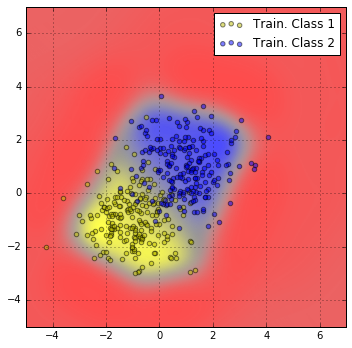

In [11]:
# TODO fix these probabilities

p_c1_c2_b_g_x = np.vstack((prediction_c1_c2[:,0]*prediction_f_b[:,0], 
                           prediction_c1_c2[:,1]*prediction_f_b[:,0], 
                           prediction_f_b[:,1])).T

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

extent=(x1_min, x1_max, x2_min, x2_max)
plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
plot_points(fig, x, y, MX1, MX2)

fig.savefig('bc_fig_bcd_5.pdf')

# Simulate the 2D example in 1D

The following examples are a simplification of the 2D example. They are not mapped one to one but they should be useful to understand the method.

## 0.1. Given data and its likelihood

We can compute first the likelihood of the data given each class and given that it belongs to the _foreground_ data
$$ p(x|f, C_i) \text{ where } i = 1 \dots k $$

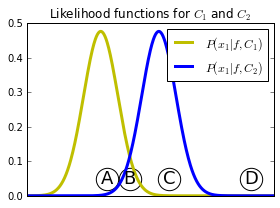

In [12]:
estimator_c1 = MyMultivariateNormal(mean=[-np.sqrt(2)], cov=[[0.7]])
estimator_c2 = MyMultivariateNormal(mean=[ np.sqrt(2)], cov=[[0.7]])

p_x_g_f_c1 = estimator_c1.score(x1_grid.reshape(-1,1))
p_x_g_f_c2 = estimator_c2.score(x1_grid.reshape(-1,1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Likelihood functions for $C_1$ and $C_2$')

ax.plot(x1_grid.reshape(-1,1), p_x_g_f_c1, color='y', label='$P(x_1|f, C_1)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_x_g_f_c2, color='b', label='$P(x_1|f, C_2)$', linewidth=3)

ax.set_ylim([0,.5])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right')

x1_predict = np.array([[x1, 0.05] for x1, x2 in x_predict])
ax_scatter_question(ax, x1_predict[:-1], notes[:-1])

fig.savefig('bc_fig_density_a_b.pdf')

## 0.2. Posterior probabilities _Class 1_ vs _Class 2_

From the two Gaussians we can compute the posterior probability per each class and use this as our pre-trained model.

$$
\begin{align}
 p(C_i | f, x) &= \frac{p(x | f, C_i) p(f, C_i)}{p(x , f)} \\
 &= \frac{p(x | f, C_i) p(f, C_i)}{\sum_{i=1}^k p(x | f, C_i) p(f, C_i)} \\
 &= \frac{p(x | f, C_i) p(f, C_i)}{\sum_{i=1}^k p(x | f, C_i) p(f, C_i)}
\end{align}
$$

because (TODO understand why this is true)

$$ p(f,Ci) = p(Ci) $$

we can write the previous equation in the form

$$ p(C_i | f, x) = \frac{p(x | f, C_i) p(C_i)}{\sum_{i=1}^k p(x | f, C_i) p(C_i)} $$

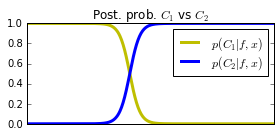

In [13]:
p_f_c1 = 0.5
p_f_c2 = 1 - p_f_c1

p_x_f = p_x_g_f_c1*p_f_c1 + p_x_g_f_c2*p_f_c2

p_c1_g_f_x = p_x_g_f_c1*p_f_c1/p_x_f
p_c2_g_f_x = p_x_g_f_c2*p_f_c2/p_x_f

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Post. prob. $C_1$ vs $C_2$')

ax.plot(x1_grid.reshape(-1,1), p_c1_g_f_x, color='y', label='$p(C_1|f,x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_c2_g_f_x, color='b', label='$p(C_2|f,x)$', linewidth=3)

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_posterior_c1_c2_g_f_x.pdf')

## 1. Generate _background_ data

We generate uniformly some background data

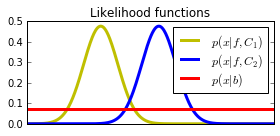

In [14]:
class MyUniformDistribution(object):
    def __init__(self, mean=[0], base=1, max_value=None):
        self.mean = np.array(mean)
        self.d = len(mean)
        self.base = base
        if max_value is None:
            self.max_value = 1.0/(self.base * self.d)
        
    def score(self, x):
        return self.max_value*np.array(np.abs(x-self.mean) <= self.base/2.0, dtype='int')
        
estimator_b = MyUniformDistribution(mean=[0], base=2*np.sqrt(2*np.power(5,2)))

p_x_g_b = estimator_b.score(x1_grid.reshape(-1,1))

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Likelihood functions')

ax.plot(x1_grid.reshape(-1,1), p_x_g_f_c1, color='y', label='$p(x|f,C_1)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_x_g_f_c2, color='b', label='$p(x|f,C_2)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_x_g_b, color='r', label='$p(x|b)$', linewidth=3)

ax.set_ylim([0,.5])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_density_c1_c2_b.pdf')

## 2. Posterior probabilities _foreground_ vs _background_

The likelihood of $x$ given that the points come from the _foreground_ is

$$
\begin{align}
p(x|f) &= \frac{p(x,f)}{p(f)} \\
       &= \frac{\sum_{i=1}^k p(x,f,C_i)}{p(f)} \\
       &= \frac{\sum_{i=1}^k p(x|f,C_i) p(C_i|f) p(f)}{p(f)} \\
       &= \sum_{i=1}^k p(x|f,C_i) p(C_i|f)
\end{align}
$$

And because (TODO see how to compute likelihood of x give f as the first part is not an equality)

$$ p(C_i | f) \ne p(C_i, f) = p(C_i) $$

We can write

$$ p(x|f) = \sum_{i=1}^k p(x|f,C_i) p(C_i) $$

The posterior probability of the foreground is

$$ p(f | x) = \frac{p(x|f)  p(f)}{p(x)} = \frac{p(x|f)  p(f)}{p(x|f)p(f) + p(x|b)p(b)}$$

and for the background is

$$ p(b | x) = \frac{p(x|b)  p(b)}{p(x)}$$

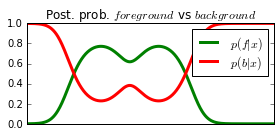

In [15]:
p_f = 0.5
p_b = 1-p_f

p_x_g_f = p_x_g_f_c1*p_f_c1 + p_x_g_f_c2*p_f_c2

p_x = p_x_g_f*p_f+p_x_g_b*p_b

p_f_g_x = np.array((p_x_g_f*p_f)/p_x)
p_b_g_x = np.array((p_x_g_b*p_b)/p_x)

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Post. prob. $foreground$ vs $background$')

ax.plot(x1_grid.reshape(-1,1), p_f_g_x, color='g', label='$p(f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_b_g_x, color='r', label='$p(b|x)$', linewidth=3)

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_posterior_f_b_g_x.pdf')

## 3. Posterior probabilities _Class 1_ vs _Class 2_ vs _background_

Now with the background we can compute the new posterior probabilities

$$ p(C_i, f | x) = \frac{p(x | f, C_i)  p(f, C_i)}{\sum_{i=0}^k p(x | f, C_i)  p(f, C_i)} $$

or 

$$
\begin{align}
p(C_i | x) &= p(C_i,f|x) \\
           &= \frac{p(C_i,f,x)}{p(x)} \\
           & = \frac{p(C_i|f,x)p(f|x)p(x)}{p(x)} \\
           & = p(C_i|f,x)p(f|x)
\end{align}
$$

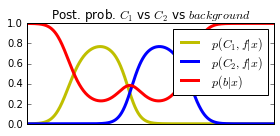

In [16]:
# TODO why this does not work?
#p_c1_g_x = p_x_g_f_c1/(p_x_g_f_c1+p_x_g_f_c2+p_x_g_b)
#p_c2_g_x = p_x_g_f_c2/(p_x_g_f_c1+p_x_g_f_c2+p_x_g_b)

p_c1_g_x = p_c1_g_f_x*p_f_g_x
p_c2_g_x = p_c2_g_f_x*p_f_g_x

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Post. prob. $C_1$ vs $C_2$ vs $background$')

ax.plot(x1_grid.reshape(-1,1), p_c1_g_x.reshape(-1,1), color='y', label='$p(C_1,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_c2_g_x.reshape(-1,1), color='b', label='$p(C_2,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_b_g_x.reshape(-1,1), color='r', label='$p(b|x)$', linewidth=3)

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_posterior_c1_c2_b.pdf')

## Familiarity approach

Given the same data and the same logistic regression we proceed to the first step.

$$ r(x) = \frac{p(f|x)}{p(b|x)} = \frac{p(f,x)p(x)}{p(b,x)p(x)} = \frac{p(f,x)}{p(b,x)}$$

we will define a relative _foreground_ density as 

$$ q_f(x) = \frac{p(x,f)}{\max{p(x,f)}} $$

and the relative _background_ density as 

$$ q_b(x) = \frac{p(x,b)}{\max{p(x,f)}} $$

## 1. Learn function $q_f(x) \in [0,1]$

$$ q_f(x) = \frac{p(x,f)}{\max(p(x,f))} $$

length of unique values = 230400


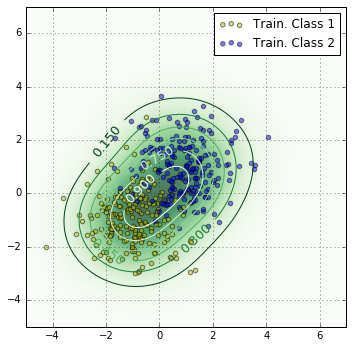

In [17]:
np.random.seed(42)

x = np.concatenate((model_c1.sample(int(N/2)),
                    model_c2.sample(int(N/2))))
y = np.concatenate((np.zeros(int(N/2)),
                    np.ones(int(N/2))))

kde = KernelDensity()
kde.fit(x)
prediction = np.exp(kde.score_samples(x_grid))

qf = prediction.reshape(len(x2_grid), len(x1_grid))
z_qf = qf/qf.max()

fig = plt.figure(figsize=(5,5))
plot_points_predictions(fig, x, y, z_qf, MX1, MX2, cmap=cm.Greens_r, cmap_r=cm.Greens, loc='upper right')
fig.savefig('bc_fig_bcf_3_kde.pdf')

length of unique values = 230400


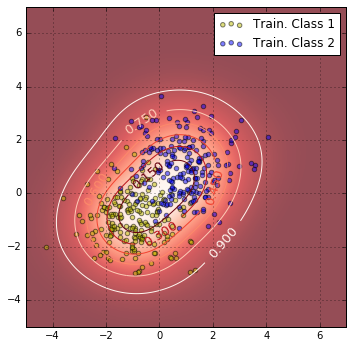

In [18]:
mu0 = 1.0
mu1 = 0.0

qb = affine_bias(z_qf,mu0,mu1)

fig = plt.figure(figsize=(5,5))
plot_points_predictions(fig, x, y, qb, MX1, MX2, cmap=cm.Reds_r, cmap_r=cm.Reds, loc='upper right')
fig.savefig('bc_fig_bcf_4_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: invalid value encountered in true_divide


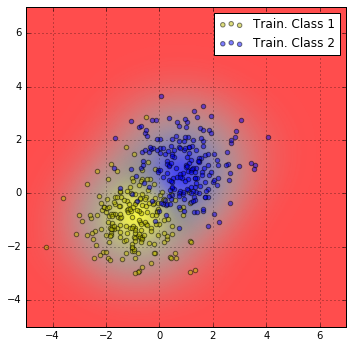

In [19]:
p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(z_qf, Z_c1_c2, 1-Z_c1_c2, mu0, mu1)

p_c1_c2_b_g_x = np.hstack((p_c1_f_g_x.reshape(-1,1), p_c2_f_g_x.reshape(-1,1), p_b_g_x.reshape(-1,1)))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

extent=(x1_min, x1_max, x2_min, x2_max)
plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
plot_points(fig, x, y, MX1, MX2)

fig.savefig('bc_fig_bcf_5_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

length of unique values = 1
Unique value =  0.5


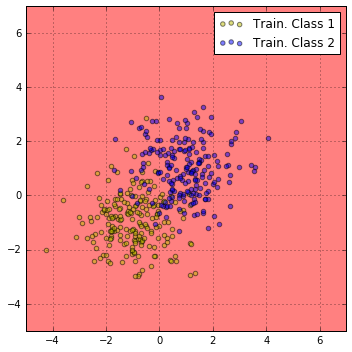

In [20]:
mu0 = 0.5
mu1 = 0.5

qb = affine_bias(z_qf,mu0,mu1)

fig = plt.figure(figsize=(5,5))
plot_points_predictions(fig, x, y, qb, MX1, MX2, cmap=cm.Reds_r, cmap_r=cm.Reds, loc='upper right')
fig.savefig('bc_fig_bcf_4_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

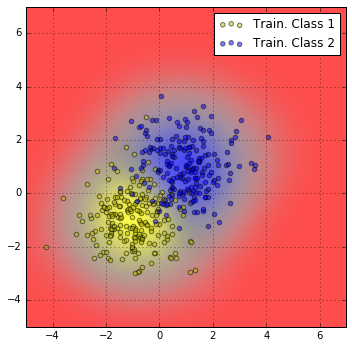

In [21]:
p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(z_qf, Z_c1_c2, 1-Z_c1_c2, mu0, mu1)

p_c1_c2_b_g_x = np.hstack((p_c1_f_g_x.reshape(-1,1), p_c2_f_g_x.reshape(-1,1), p_b_g_x.reshape(-1,1)))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

extent=(x1_min, x1_max, x2_min, x2_max)
plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
plot_points(fig, x, y, MX1, MX2)

fig.savefig('bc_fig_bcf_5_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

length of unique values = 230400


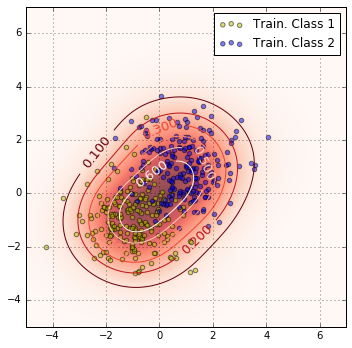

In [22]:
mu0 = 0.0
mu1 = 0.7

qb = affine_bias(z_qf,mu0,mu1)

fig = plt.figure(figsize=(5,5))
plot_points_predictions(fig, x, y, qb, MX1, MX2, cmap=cm.Reds_r, cmap_r=cm.Reds, loc='upper right')
fig.savefig('bc_fig_bcf_4_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

Unique value =  0.411764705882


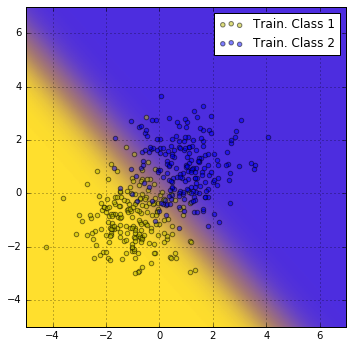

In [23]:
p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(z_qf, Z_c1_c2, 1-Z_c1_c2, mu0, mu1)

p_c1_c2_b_g_x = np.hstack((p_c1_f_g_x.reshape(-1,1), p_c2_f_g_x.reshape(-1,1), p_b_g_x.reshape(-1,1)))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

extent=(x1_min, x1_max, x2_min, x2_max)
plot_probabilities(p_c1_c2_b_g_x, extent=(x1_min, x1_max, x2_min, x2_max))
plot_points(fig, x, y, MX1, MX2)

fig.savefig('bc_fig_bcf_5_kde_mu0_{:02.0f}_mu1_{:02.0f}.pdf'.format(10*mu0, 10*mu1))

(480,)


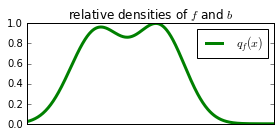

In [24]:
from sklearn.neighbors import KernelDensity

np.random.seed(42)
x = np.vstack((estimator_c1.sample(50), estimator_c2.sample(50)))

kde = KernelDensity()
kde.fit(x)

x_g_f = np.exp(kde.score_samples(x1_grid.reshape(-1,1))).reshape(-1,1)
q_f = x_g_f/x_g_f.max()

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title(r'relative densities of $f$ and $b$')
print x1_grid.shape
ax.plot(x1_grid.reshape(-1,1), q_f, color='g', label='$q_f(x)$', linewidth=3)

#ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)
plt.locator_params(axis='y',nbins=5)

fig.savefig('bc_fig_qf.pdf')

## Use an inductive bias to get $q_b(x)$

For example, we can use an affine function

$$ q_b(x) = (1-q_f(x))\mu(0) + q_f(x)\mu(1) $$

(230400, 2)


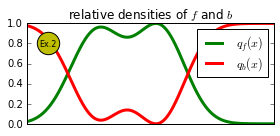

In [25]:
mu0 = 1.0
mu1 = 0.0

q_b = (1-q_f)*mu0 + q_f*mu1
q_b = q_b

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title(r'relative densities of $f$ and $b$')
print x_grid.shape
ax.plot(x1_grid.reshape(-1,1), q_f, color='g', label='$q_f(x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), q_b, color='r', label='$q_b(x)$', linewidth=3)

ax_scatter_question(ax, np.array([[-4,0.8]]), (['Ex.2']), text_size=8, zorder=100, clip_on=False, color='y')

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)
plt.locator_params(axis='y',nbins=5)

fig.savefig('bc_fig_qf_qb_mu0_{}_mu1_{}.pdf'.format(int(10*mu0), int(10*mu1)))

## Compute the posterior probabilities

with the ratio we can retrieve the probability of _background_

$$ p(b|x) = \frac{1}{1 + r(x)} $$

and the posterior probability for each _foreground_ class

$$ p(C_i|x) = \frac{p(C_i|f,x)r(x)}{1+r(x)} $$


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: invalid value encountered in true_divide


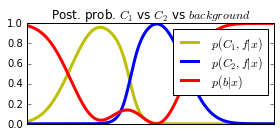

In [26]:
p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(q_f, p_c1_g_f_x, p_c2_g_f_x, mu0, mu1)

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Post. prob. $C_1$ vs $C_2$ vs $background$')
ax.plot(x1_grid.reshape(-1,1), p_c1_f_g_x, color='y', label='$p(C_1,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_c2_f_g_x, color='b', label='$p(C_2,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_b_g_x, color='r', label='$p(b|x)$', linewidth=3)

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_posterior_c1_c2_b_g_x_mu0_{}_mu1_{}.pdf'.format(int(10*mu0), int(10*mu1)))

(480,)


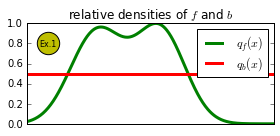

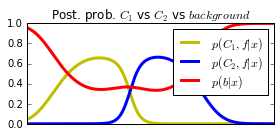

In [27]:
mu0 = 0.5
mu1 = 0.5

q_b = (1-q_f)*mu0 + q_f*mu1

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title(r'relative densities of $f$ and $b$')
print x1_grid.shape
ax.plot(x1_grid.reshape(-1,1), q_f, color='g', label='$q_f(x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), q_b, color='r', label='$q_b(x)$', linewidth=3)

ax_scatter_question(ax, np.array([[-4,0.8]]), (['Ex.1']), text_size=8, zorder=100, clip_on=False, color='y')

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
plt.locator_params(axis='y',nbins=5)
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_qf_qb_mu0_{}_mu1_{}.pdf'.format(int(10*mu0), int(10*mu1)))

p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(q_f, p_c1_g_f_x, p_c2_g_f_x, mu0, mu1)

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Post. prob. $C_1$ vs $C_2$ vs $background$')
ax.plot(x1_grid.reshape(-1,1), p_c1_f_g_x, color='y', label='$p(C_1,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_c2_f_g_x, color='b', label='$p(C_2,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_b_g_x, color='r', label='$p(b|x)$', linewidth=3)

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_posterior_c1_c2_b_g_x_mu0_{}_mu1_{}.pdf'.format(int(10*mu0), int(10*mu1)))

(480,)


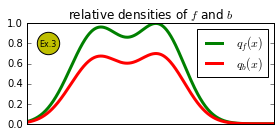

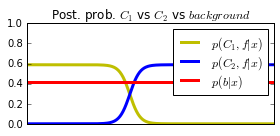

In [28]:
mu0 = 0.0
mu1 = 0.7

q_b = (1-q_f)*mu0 + q_f*mu1

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title(r'relative densities of $f$ and $b$')
print x1_grid.shape
ax.plot(x1_grid.reshape(-1,1), q_f, color='g', label='$q_f(x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), q_b, color='r', label='$q_b(x)$', linewidth=3)

ax_scatter_question(ax, np.array([[-4,0.8]]), (['Ex.3']), text_size=8, zorder=100, clip_on=False, color='y')

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
plt.locator_params(axis='y',nbins=5)
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_qf_qb_mu0_{}_mu1_{}.pdf'.format(int(10*mu0), int(10*mu1)))

p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(q_f, p_c1_g_f_x, p_c2_g_f_x, mu0, mu1)

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title('Post. prob. $C_1$ vs $C_2$ vs $background$')
ax.plot(x1_grid.reshape(-1,1), p_c1_f_g_x, color='y', label='$p(C_1,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_c2_f_g_x, color='b', label='$p(C_2,f|x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), p_b_g_x, color='r', label='$p(b|x)$', linewidth=3)

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_posterior_c1_c2_b_g_x_mu0_{}_mu1_{}.pdf'.format(int(10*mu0), int(10*mu1)))

(480,)


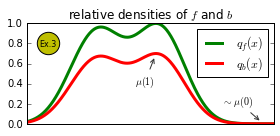

In [29]:
q_b = (1-q_f)*mu0 + q_f*mu1

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_title(r'relative densities of $f$ and $b$')
print x1_grid.shape
ax.plot(x1_grid.reshape(-1,1), q_f, color='g', label='$q_f(x)$', linewidth=3)
ax.plot(x1_grid.reshape(-1,1), q_b, color='r', label='$q_b(x)$', linewidth=3)

mu0_x = x1_grid[-20]
mu0_y = mu0
ax.annotate('$\sim \mu(0)$', xy=(mu0_x, mu0_y), xytext=(mu0_x-2, mu0_y+0.2),
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                                color="0.2",
                                shrinkA=2, shrinkB=5,),
            )

mu1_x = x1_grid[q_f.argmax()]
mu1_y = mu1
ax.annotate('$\mu(1)$', xy=(mu1_x,mu1_y), xytext=(mu1_x-1, mu1_y-0.3),
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                                color="0.2",
                                shrinkA=2, shrinkB=5,),
            )

ax_scatter_question(ax, np.array([[-4,0.8]]), (['Ex.3']), text_size=8, zorder=100, clip_on=False, color='y')

ax.set_ylim([0,1])
ax.set_xlim([x1_min, x1_max])
ax.set_xticks([])
plt.locator_params(axis='y',nbins=5)
ax.legend(loc='upper right', labelspacing=0.1)

fig.savefig('bc_fig_qf_qb_mu0_{}_mu1_{}_annotated.pdf'.format(int(10*mu0), int(10*mu1)))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:113: RuntimeWarning: invalid value encountered in true_divide


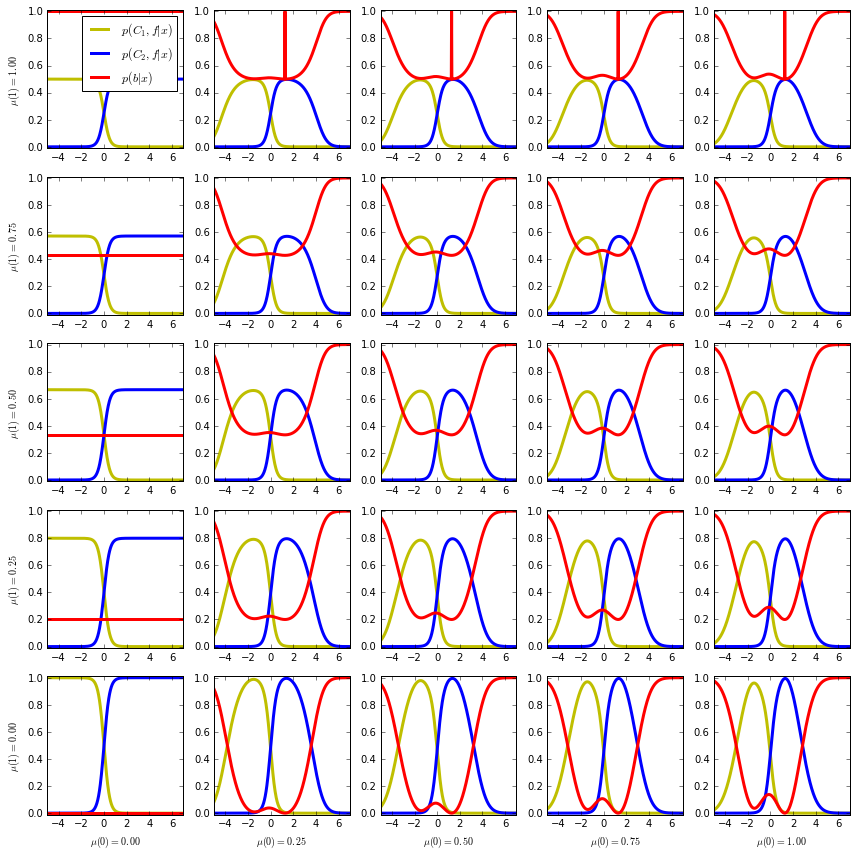

In [30]:
fig = plt.figure(figsize=(12,12))

n_values = 5
values = np.linspace(0,1,n_values)
for i, mu1 in enumerate(reversed(values)):
    for j, mu0 in enumerate(values):
        ax = plt.subplot(n_values, n_values, i*n_values+j+1)
            
        p_c1_f_g_x, p_c2_f_g_x, p_b_g_x = posterior_probs(q_f, p_c1_g_f_x, p_c2_g_f_x, mu0, mu1)

        ax.plot(x1_grid.reshape(-1,1), p_c1_f_g_x, color='y', label='$p(C_1,f|x)$', linewidth=3)
        ax.plot(x1_grid.reshape(-1,1), p_c2_f_g_x, color='b', label='$p(C_2,f|x)$', linewidth=3)
        ax.plot(x1_grid.reshape(-1,1), p_b_g_x, color='r', label='$p(b|x)$', linewidth=3)

        ax.set_ylim([0,1])
        ax.set_xlim([x1_min, x1_max])
        
        plt.xlim([x1_min, x1_max])
        plt.ylim([-0.01,1.01])

        #plt.rc('grid', linestyle="-", color='#AAAAAA')
        #plt.grid(True)
        
        if i==0 and j==0:
            plt.legend()
        
        if i == n_values-1:
            plt.xlabel('$\mu(0) = {:.2f}$'.format(mu0))
        if j == 0:
            plt.ylabel('$\mu(1) = {:.2f}$'.format(mu1))

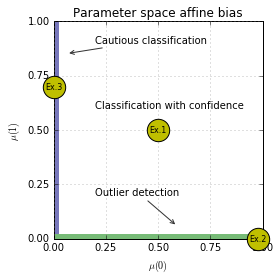

In [31]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_title('Parameter space affine bias')
ax.plot([])
ax.set_ylabel('$\mu(1)$')
ax.set_xlabel('$\mu(0)$')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True, color='gray')
ticks = ax.set_xticks([0,0.25,0.5,0.75,1.0])
ticks = ax.set_yticks([0,0.25,0.5,0.75,1.0])

fig.savefig('bc_fig_bias_3_empty.pdf')

ax.plot([0,0], [0,1], color="#7777bb", lw=10, zorder=1)

ax_scatter_question(ax, np.array([[0.0,0.7]]), (['Ex.3']), text_size=8, zorder=100, clip_on=False, color='y')
#ax.scatter([0.0], [0.7], color='red', marker='*', s=500, clip_on=False, zorder=100)
ax.annotate('Cautious classification', xy=(0.05, 0.85), xytext=(0.2, 0.9),
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                                color="0.2",
                                shrinkA=2, shrinkB=5,),
            )
fig.savefig('bc_fig_bias_3_cautious_class.pdf')

ax.plot([0,1], [0,0], color="#77bb77", lw=10, zorder=1)
#ax.scatter([1], [0], color='red', marker='*', s=500, clip_on=False, zorder=100)
ax_scatter_question(ax, np.array([[0.98,0]]), (['Ex.2']), text_size=8, zorder=100, clip_on=False, color='y')
ax.annotate('Outlier detection', xy=(0.6, 0.05), xytext=(0.2, 0.2),
            arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                                color="0.2",
                                shrinkA=2, shrinkB=5,),
            )
fig.savefig('bc_fig_bias_3_outlier_detection.pdf')

ax_scatter_question(ax, np.array([[.5,.5]]), (['Ex.1']), text_size=8, zorder=100, clip_on=False, color='y')
#ax.scatter([0.5], [0.5], color='red', marker='*', s=500, clip_on=False, zorder=100)
ax.annotate('Classification with confidence', xy=(0.5, 0.5), xytext=(0.2, 0.6)
            )
fig.savefig('bc_fig_bias_3_class_confidence.pdf')

(480,)
(480, 3)


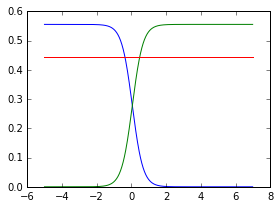

In [32]:
x = np.concatenate((estimator_c1.sample(int(N/2)),
                    estimator_c2.sample(int(N/2))))
y = np.concatenate((np.zeros(int(N/2)),
                    np.ones(int(N/2))))

mu0 = 0.0
mu1 = 0.8

cwc = ConfidentClassifier(classifier=LogisticRegression(), mu1=mu1, mu0=mu0)

cwc.fit(x, y, total_classes=2)

prediction = cwc.predict_proba(x1_grid.reshape(-1,1))

print x1_grid.shape
print prediction.shape

plt.plot(x1_grid, prediction)

$$ p(f_c,f|x) = p(f_c|f,x) \frac{p(f|x)}{p(b|x)} p(b|x) $$ 

From the previous equality I am trying to demonstrate why this holds:

$$ p(f_c,f|x) = p(f_c|f,x) p(f|x) $$

I am using just the multiplication rule:

$$ P(A,B) = P(A|B) P(B) $$

And the chain rule

$$ P(A,B,C) = P(A | B,C) P(B,C) $$

and the division rule if we move P(B) to the other side

$$ \frac{P(A,B)}{P(B)} = P(A|B) $$

Then this is my approach: we first apply the division rule

$$ p(f_c, f|x) = \frac{p(f_c, f, x)}{p(x)} $$

Then we can apply one step of the chain rule on the numerator

$$ \frac{p(f_c, f, x)}{p(x)} = \frac{p(f_c | f, x) p(f,x)}{p(x)} $$

Then we can apply the division rule back but only on the p(f,x) as in p(f_c|f,x) the x is in the conditional side

$$ \frac{p(f_c | f, x) p(f,x)}{p(x)} = \frac{p(f_c | f, x)}{p(x)} p(f|x) $$

What if we apply all the chain rule

$$ \frac{p(f_c, f, x)}{p(x)} = \frac{p(f_c | f, x) p(f|x) p(x)}{p(x)} $$

Then we can remove the p(x) on both parts of the fraction

$$ \frac{p(f_c | f, x) p(f|x) p(x)}{p(x)} = p(f_c | f, x) p(f|x) $$